# Part1: Data sanity check and exploration

data is taken from https://www.kaggle.com/c/santander-customer-transaction-prediction

In this challenge, Santander invites Kagglers to help them identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data they have available to solve this problem.

The data is anonimyzed, each row containing 200 numerical values identified just with a number.

In this notebook we have a first look at the data and identify peculiar properties.

## Load packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
#from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

## Load data

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

## Basic checks

In [3]:
print (df_train.shape)
print (df_test.shape)
df_train.head(2)
df_test.head(2)

(200000, 202)
(200000, 201)


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760


There are 89.951% target values with 0
There are 10.049% target values with 1


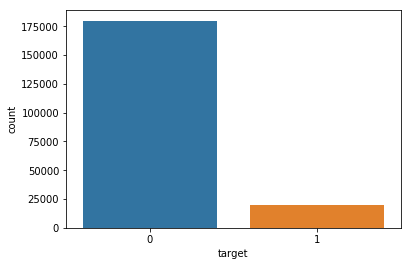

In [4]:
sns.countplot(df_train['target'])
print("There are {}% target values with 0".format(100 * df_train["target"].value_counts()[0]/df_train.shape[0]))
print("There are {}% target values with 1".format(100 * df_train["target"].value_counts()[1]/df_train.shape[0]))

Note that we have only 10% of data from class 1. In other words dataset is imbalanced.

### Check missing data 

In [5]:
# useful function from https://www.kaggle.com/gpreda/santander-eda-and-prediction
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))


In [6]:
missing_data(df_train)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [7]:
missing_data(df_test)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


Everything seems to be filled. Now let's prepare data for future usage in NN

### Split into train0, train1 and test datasets

In [8]:
Y_train_full = df_train['target']
X_train_full = df_train.drop(['target', 'ID_code'], axis=1)

X_train_0_full = (df_train.loc[lambda x: x['target'] < 1, :]).drop(['ID_code'], axis=1)
X_train_1 = (df_train.loc[lambda x: x['target'] > 0, :]).drop(['ID_code'], axis=1)
X_train_0 = X_train_0_full.head(20098) #make train_0 and train_1 equal for following plots 
#X_train_0 = X_train_0_full

df_train_sample = pd.concat([X_train_1,X_train_0]).sample(frac=1) #merge 2 dataframes and reshuffle
X_train = df_train_sample.drop(['target'],axis=1)
Y_train = df_train_sample['target']
X_test = df_test.drop(['ID_code'], axis=1)


### Check for outliers

In [9]:
#FixME: move me in another notebook!
def detect_outlier(data_1,thresh):
    outliers=[]
    threshold=thresh
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    #print (mean_1, std_1)
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [10]:
for i in range (200):
    name = 'var_'+str(i)    
    if(detect_outlier(X_train[name],5)):
        print (name, detect_outlier(X_train[name],5))
        #remove variables with outliers
        X_train = X_train.drop([name], axis=1)
        X_test = X_test.drop([name], axis=1)
        X_train_full = X_train_full.drop([name], axis=1)
print (X_train.shape)
print (X_test.shape)

(40196, 200)
(200000, 200)


### Mean and standart deviation of datasets

In [11]:
means_train=[]
stds_train=[]
means_train_0=[]
stds_train_0=[]
means_train_1=[]
stds_train_1=[]

means_test=[]
stds_test=[]

for i in range (200):
    name = 'var_'+str(i)
    means_train.append(X_train[name].mean())
    stds_train.append(X_train[name].std())    
    means_train_0.append(X_train_0[name].mean())
    stds_train_0.append(X_train_0[name].std())    
    means_train_1.append(X_train_1[name].mean())
    stds_train_1.append(X_train_1[name].std())    
    means_test.append(X_test[name].mean())
    stds_test.append(X_test[name].std())


/home/anastasia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


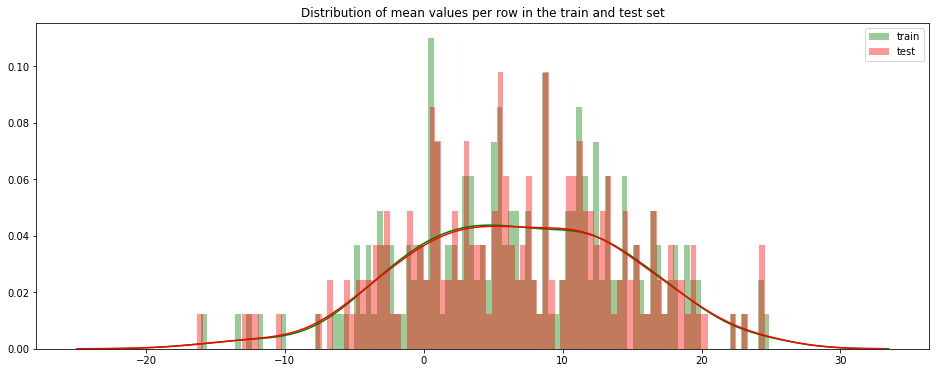

In [12]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(means_train,color="green", kde=True,bins=100, label='train')
sns.distplot(means_test,color="red", kde=True,bins=100, label='test')
plt.legend()
plt.show()


    

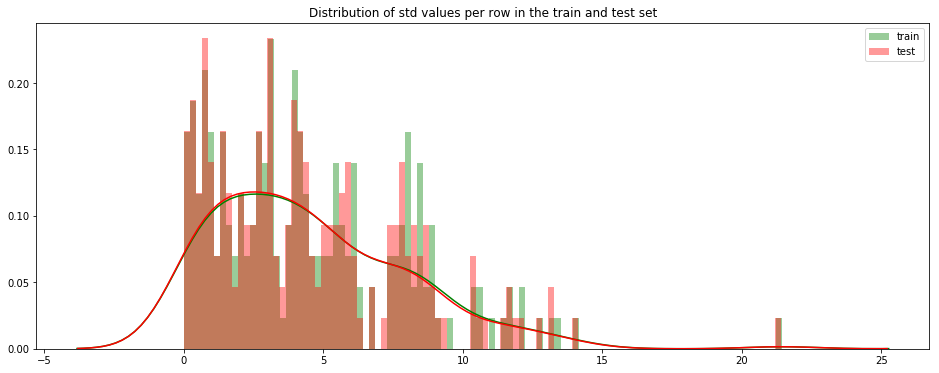

In [13]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(stds_train,color="green", kde=True,bins=100, label='train')
sns.distplot(stds_test,color="red", kde=True,bins=100, label='test')
plt.legend()
plt.show()

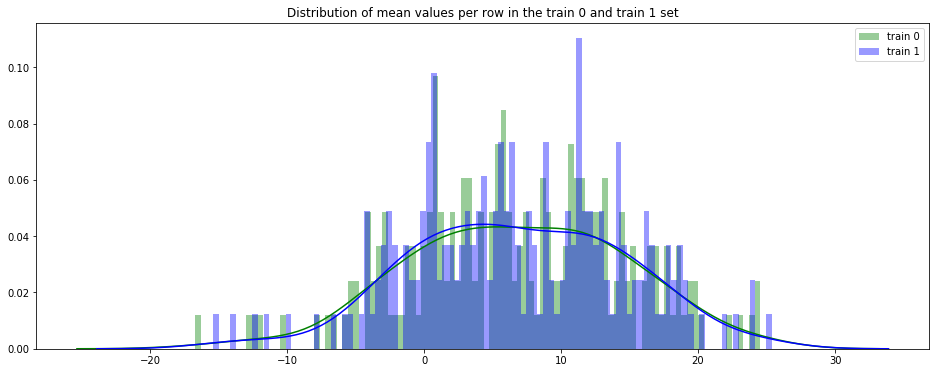

In [14]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train 0 and train 1 set")
sns.distplot(means_train_0,color="green", kde=True,bins=100, label='train 0')
sns.distplot(means_train_1,color="blue", kde=True,bins=100, label='train 1')
plt.legend()
plt.show()

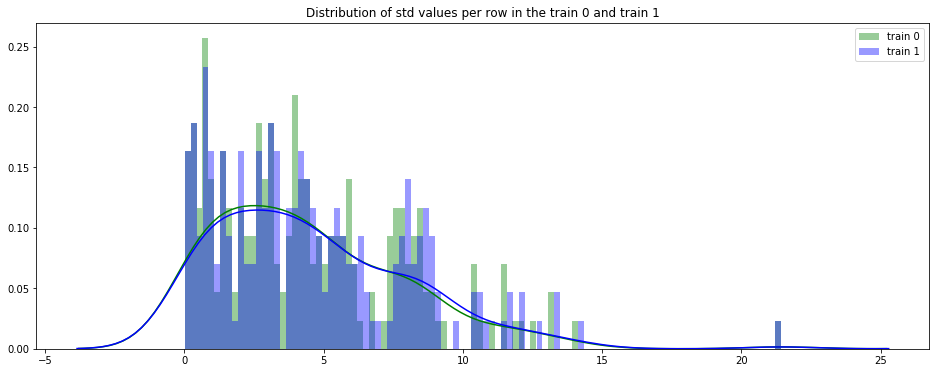

In [15]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train 0 and train 1")
sns.distplot(stds_train_0,color="green", kde=True,bins=100, label='train 0')
sns.distplot(stds_train_1,color="blue", kde=True,bins=100, label='train 1')
plt.legend()
plt.show()

### Correlations


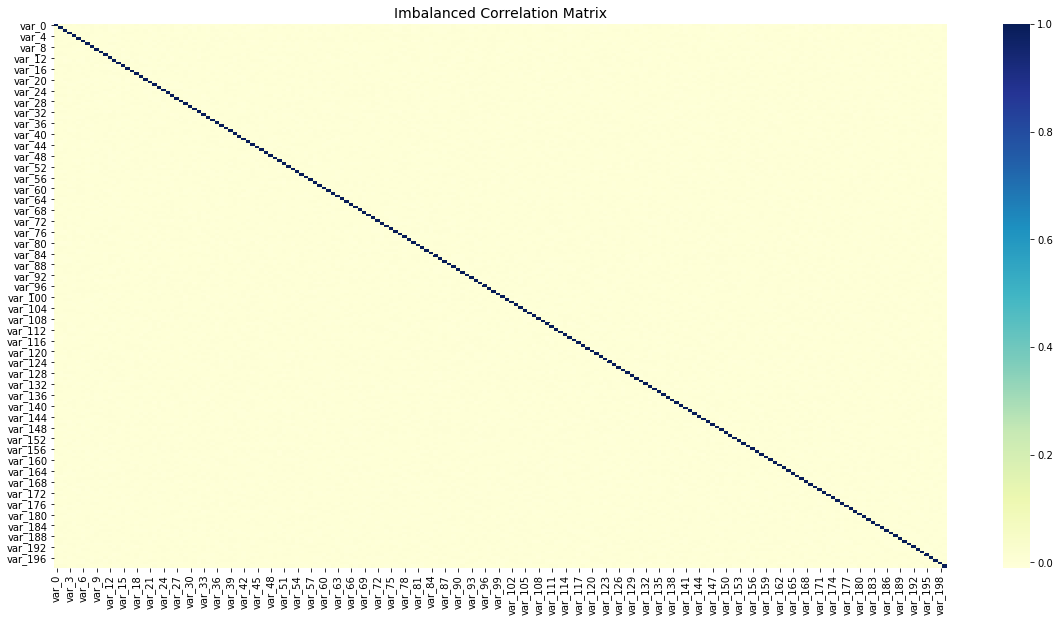

In [16]:
# Sample figsize in inches
fig_train_full, ax_train_full = plt.subplots(figsize=(20,10))         

# Imbalanced DataFrame Correlation
corr_train_full = X_train_full.corr(method='pearson', min_periods=100)
sns.heatmap(corr_train_full, cmap='YlGnBu', annot_kws={'size':30}, ax=ax_train_full)
ax_train_full.set_title("Imbalanced Correlation Matrix", fontsize=14)

plt.show()

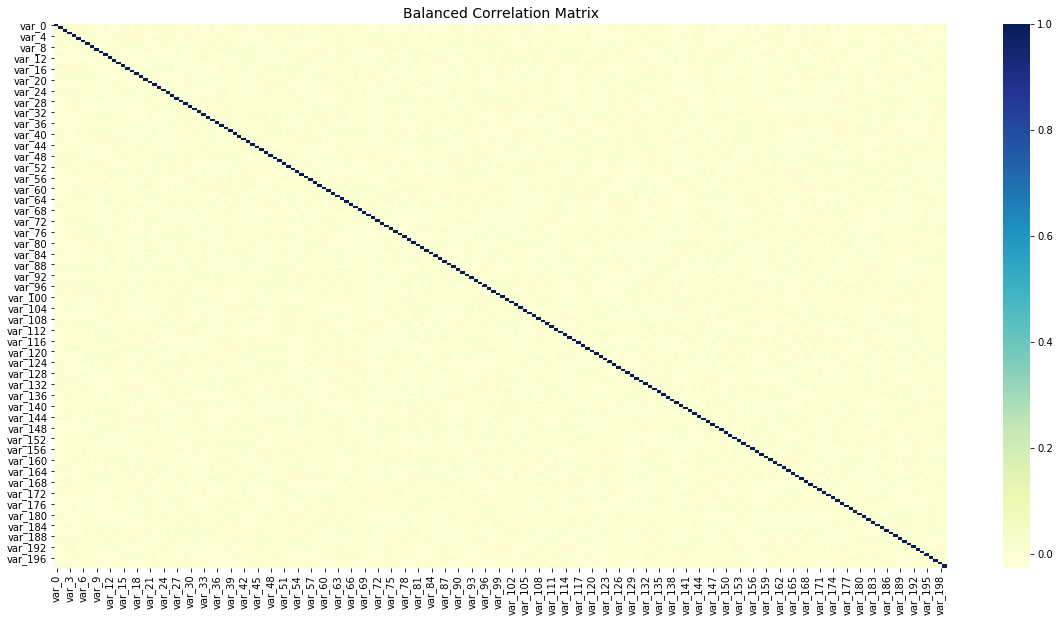

In [17]:
## Sample figsize in inches
fig_train, ax_train = plt.subplots(figsize=(20,10))         

# Imbalanced DataFrame Correlation
corr_train = X_train.corr(method='pearson', min_periods=100)
sns.heatmap(corr_train, cmap='YlGnBu', annot_kws={'size':30}, ax=ax_train)
ax_train.set_title("Balanced Correlation Matrix", fontsize=14)
plt.show()

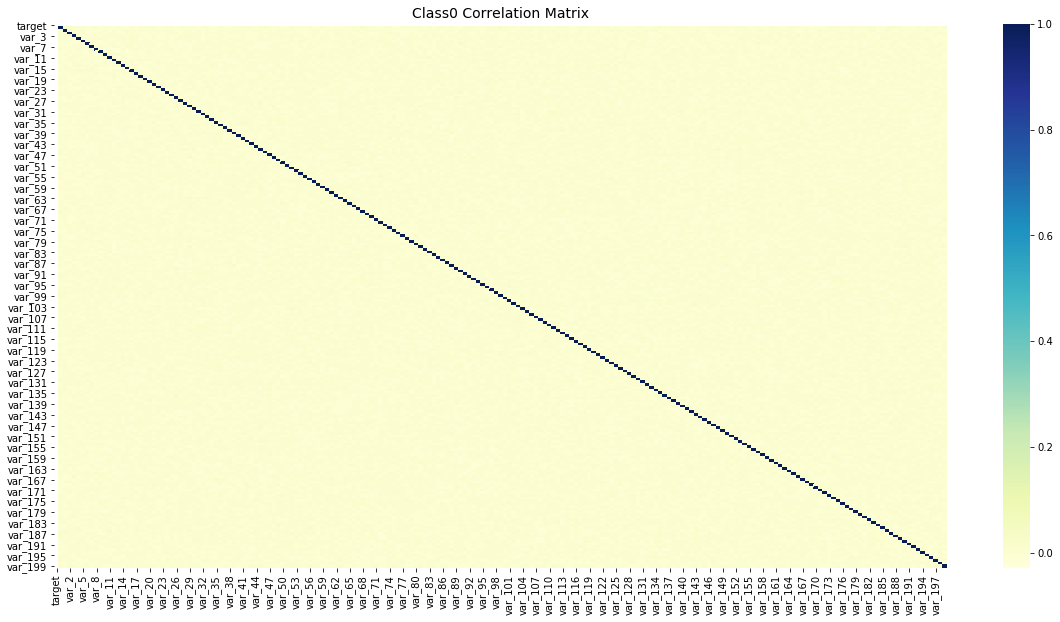

In [18]:
# Sample figsize in inches
fig_train_0, ax_train_0 = plt.subplots(figsize=(20,10))         

# Imbalanced DataFrame Correlation
corr_train_0 = X_train_0.corr(method='pearson', min_periods=100)
sns.heatmap(corr_train_0, cmap='YlGnBu', annot_kws={'size':30}, ax=ax_train_0)
ax_train_0.set_title("Class0 Correlation Matrix", fontsize=14)
plt.show()


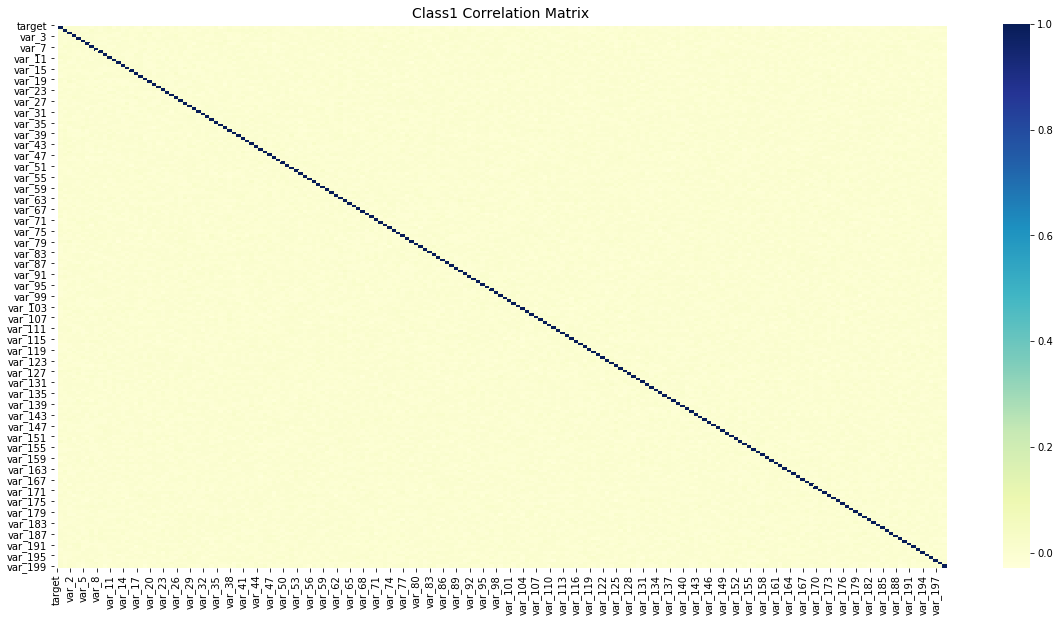

In [20]:
## Sample figsize in inches
fig_train_1, ax_train_1 = plt.subplots(figsize=(20,10))         

## Imbalanced DataFrame Correlation
corr_train_1 = X_train_1.corr(method='pearson', min_periods=100)
sns.heatmap(corr_train_1, cmap='YlGnBu', annot_kws={'size':30}, ax=ax_train_1)
ax_train_1.set_title("Class1 Correlation Matrix", fontsize=14)
plt.show()

## Conclusion, observations

* dataset is imbalanced: 90% from class 0 and 10% from class 1
* Mean and standart deviations are similar in training and testing data and also for different classes in training dataset